In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


df_train = pd.read_csv('../datasets/insurance_train.csv')
df_test = pd.read_csv('../datasets/insurance_test.csv')

df_train.head()

,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


Пропуски в обучающей выборке:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в тестовой выборке:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


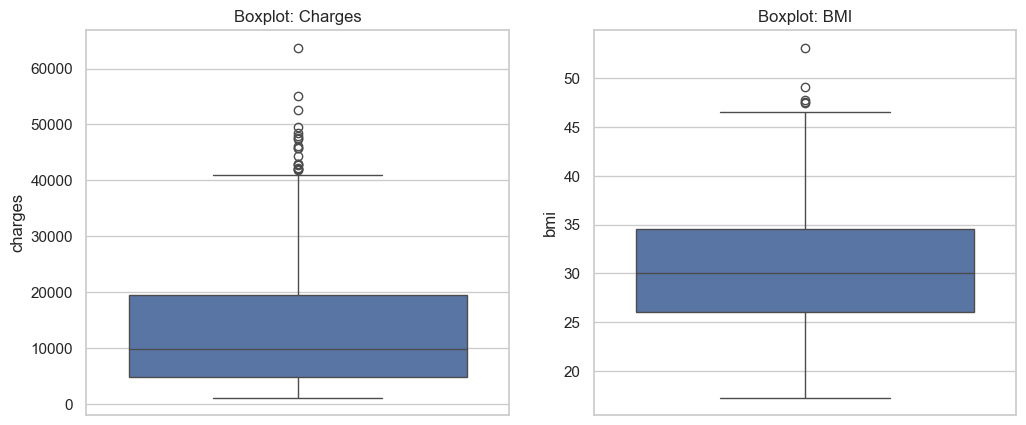

,age,bmi,children,charges
count,338.000000,338.000000,338.000000,338.000000
mean,38.810651,30.672751,1.153846,14092.861924
std,13.637734,6.309709,1.205822,12792.472722
min,18.000000,17.290000,0.000000,1121.873900
25%,27.000000,26.053750,0.000000,4811.304137
50%,38.000000,30.065000,1.000000,9891.530425
75%,50.000000,34.595000,2.000000,19423.699050
max,64.000000,53.130000,5.000000,63770.428010


In [192]:
print("Пропуски в обучающей выборке:")
print(df_train.isna().sum())
print("\nПропуски в тестовой выборке:")
print(df_test.isna().sum())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_train['charges'])
plt.title('Boxplot: Charges')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_train['bmi'])
plt.title('Boxplot: BMI')
plt.show()

df_train.describe()

In [194]:
# Преобразуем категориальные признаки (sex, smoker, region) в числовые
# Используем One-Hot Encoding для региона и бинарное кодирование для пола и курения

def encode_features(df):
    df_encoded = df.copy()

    # Бинарные
    df_encoded['sex'] = df_encoded['sex'].map({'male': 0, 'female': 1})
    df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})

    df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)

    return df_encoded

train_enc = encode_features(df_train)
test_enc = encode_features(df_test)

train_enc.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,26,0,27.060,0,1,17043.34140,False,True,False
1,58,0,36.955,2,1,47496.49445,True,False,False
2,20,1,24.420,0,1,26125.67477,False,True,False
3,51,1,38.060,0,1,44400.40640,False,True,False
4,62,1,25.000,0,0,13451.12200,False,False,True


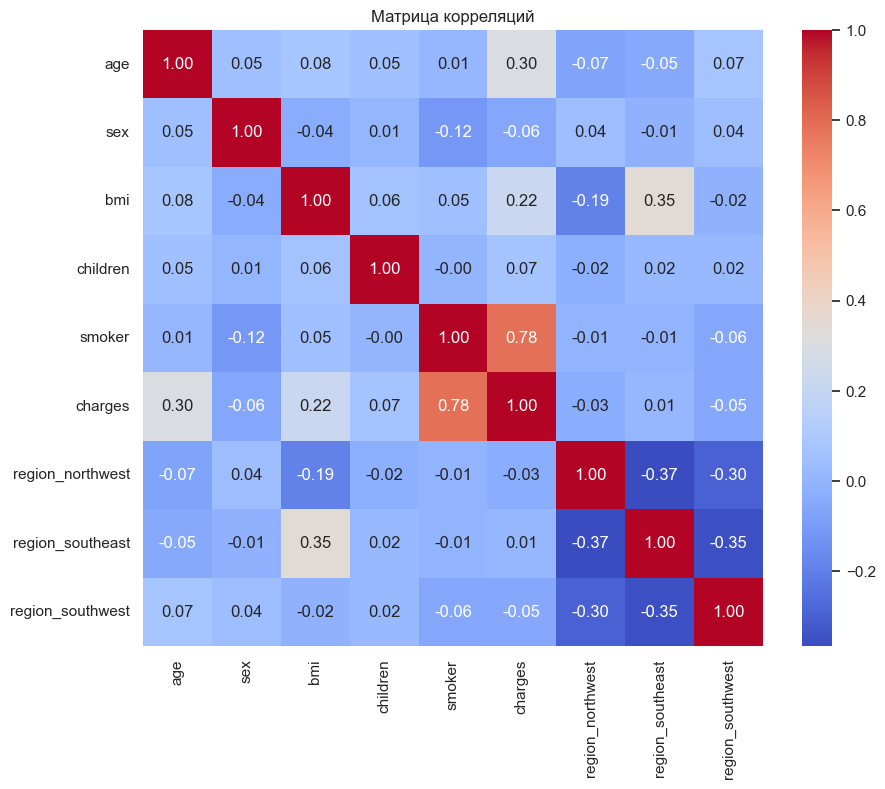

In [195]:
# Парные корреляции
corr_matrix = train_enc.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляций")
plt.show()

In [196]:
# Разделение на X и y
X_train_raw = train_enc.drop('charges', axis=1).astype(float).values
y_train = train_enc['charges'].values

X_test_raw = test_enc.drop('charges', axis=1).astype(float).values
y_test = test_enc['charges'].values

mean = X_train_raw.mean(axis=0)
std = X_train_raw.std(axis=0)

std = np.where(std == 0, 1e-8, std)

X_train_scaled = (X_train_raw - mean) / std
X_test_scaled = (X_test_raw - mean) / std

X_train = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

print(f"Размерность матрицы X_train: {X_train.shape}")

Размерность матрицы X_train: (338, 9)


In [197]:
# Аналитическое решение: w = (X^T * X)^(-1) * X^T * y

def linear_regression_analytic(X, y):
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

w_analytic = linear_regression_analytic(X_train, y_train)

print("Веса (аналитически):", w_analytic)

Веса (аналитически): [14092.8619242   3495.76949182   327.42129485  2210.57176839
   581.67513525  9859.84555479   -85.25913065  -638.00136585
  -601.39012784]


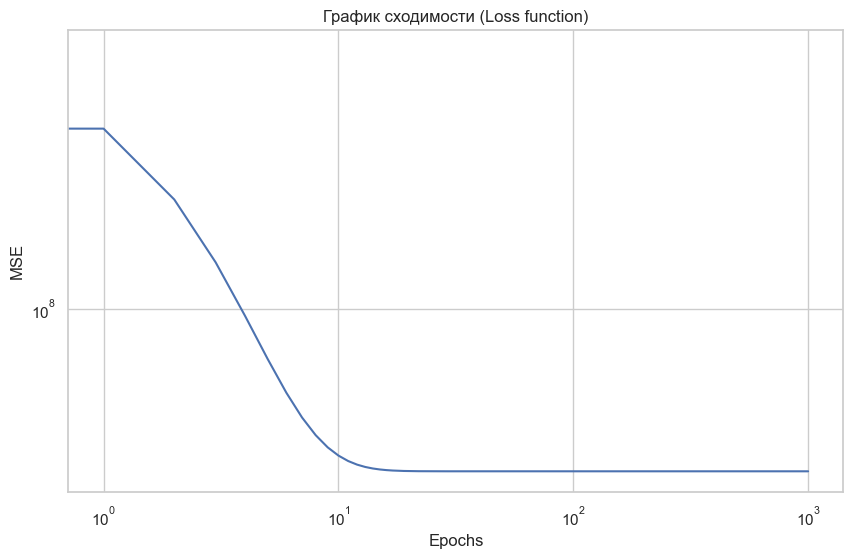

Веса (градиентный спуск): [14092.8619242   3495.76949182   327.42129485  2210.57176839
   581.67513525  9859.84555479   -85.25913065  -638.00136585
  -601.39012784]


In [198]:
# Градиентный спуск
# Функция потерь MSE: L = (1/n) * sum((y_pred - y)^2)
# Градиент: dw = (2/n) * X^T * (X*w - y)

def linear_regression_gd(X, y, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)

    loss_history = []

    for _ in range(epochs):
        y_pred = X @ w
        error = y_pred - y

        gradient = (2 / n_samples) * (X.T @ error)

        w -= learning_rate * gradient

        loss = np.mean(error ** 2)
        loss_history.append(loss)

    return w, loss_history

w_gd, loss_history = linear_regression_gd(X_train, y_train, learning_rate=0.1, epochs=1000)

plt.plot(loss_history)
plt.xscale('log')
plt.yscale('log')
plt.title("График сходимости (Loss function)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

print("Веса (градиентный спуск):", w_gd)

In [199]:
def get_mse(X, y, w):
    y_pred = X @ w
    return np.mean((y_pred - y) ** 2)

mse_analytic = get_mse(X_train, y_train, w_analytic)

mse_gd = get_mse(X_train, y_train, w_gd)

print(f"Метрики на ОБУЧАЮЩЕЙ выборке:")
print(f"MSE (аналитически): {mse_analytic:.2f}")
print(f"MSE (градиентный спуск): {mse_gd:.2f}")
print(f"Разница: {abs(mse_analytic - mse_gd):.5f}")

print(f"\nСредняя ошибка в долларах (RMSE): {np.sqrt(mse_analytic):.2f}")

Метрики на ОБУЧАЮЩЕЙ выборке:
MSE (аналитически): 44325092.03
MSE (градиентный спуск): 44325092.03
Разница: 0.00000

Средняя ошибка в долларах (RMSE): 6657.71


In [200]:
# Аналитическое решение с L2 регуляризацией
# w = (X^T * X + alpha * I)^(-1) * X^T * y
# alpha - коэффициент регуляризации

def ridge_analytic(X, y, alpha=1.0):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0

    w = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y
    return w

alpha_val = 1
w_ridge_analytic = ridge_analytic(X_train, y_train, alpha=alpha_val)

print(f"Веса Ridge аналитически (alpha={alpha_val}):", w_ridge_analytic)

Веса Ridge аналитически (alpha=1): [14092.8619242   3486.53980525   323.19124524  2204.79892372
   580.71011529  9830.83857312   -84.46552182  -633.64613204
  -598.79681259]


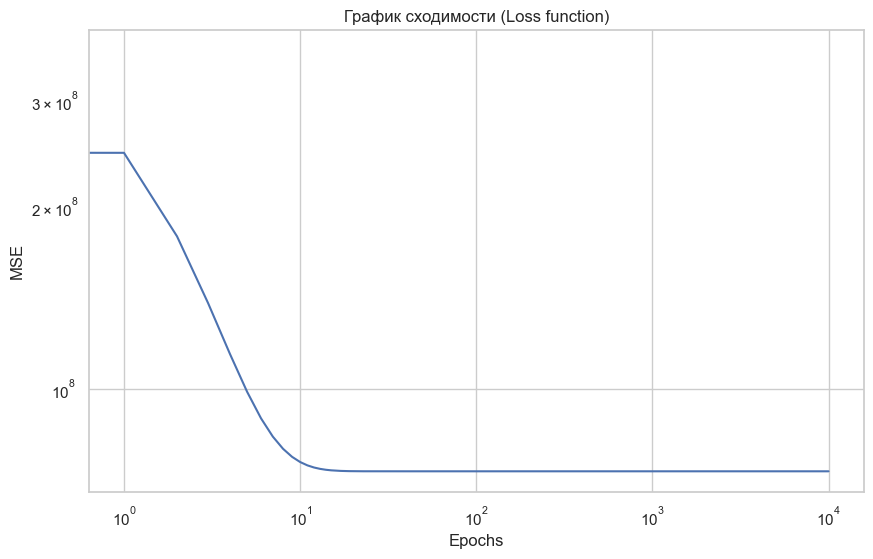

Веса Ridge GD: [14092.8619242   1829.96857662  -108.04000974  1210.79455972
   359.98012826  4948.72953729   -74.03747066  -151.48476947
  -294.91933564]


In [201]:
# Градиентный спуск с L2 регуляризацией
# Градиент: dw = (2/n) * X^T * (X*w - y) + 2 * alpha * w

def ridge_gd(X, y, learning_rate=0.01, epochs=1000, alpha=1.0):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)

    loss_history = []

    for _ in range(epochs):
        y_pred = X @ w
        error = y_pred - y

        grad_mse = (2 / n_samples) * (X.T @ error)

        w_reg = w.copy()
        w_reg[0] = 0
        grad_reg = 2 * alpha * w_reg

        gradient = grad_mse + grad_reg

        w -= learning_rate * gradient

        loss = np.mean(error ** 2)
        loss_history.append(loss)

    return w, loss_history

w_ridge_gd, loss_history = ridge_gd(X_train, y_train, learning_rate=0.1, epochs=10000, alpha=1)

plt.plot(loss_history)
plt.xscale('log')
plt.yscale('log')
plt.title("График сходимости (Loss function)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

print(f"Веса Ridge GD:", w_ridge_gd)

In [202]:
def calculate_rmse(X, y, w):
    y_pred = X @ w
    return np.sqrt(np.mean((y_pred - y) ** 2))

y_pred_const = np.full(shape=y_test.shape, fill_value=y_train.mean())
mse_const = np.sqrt(np.mean((y_pred_const - y_test) ** 2))

mse_lr = calculate_rmse(X_test, y_test, w_analytic)

mse_ridge = calculate_rmse(X_test, y_test, w_ridge_analytic)

print("Результаты на тестовой выборке (MSE):")
print("-" * 40)
print(f"Константная модель:        {mse_const:.2f}")
print(f"Линейная регрессия:        {mse_lr:.2f}")
print(f"Ridge регрессия (L2):      {mse_ridge:.2f}")

Результаты на тестовой выборке (MSE):
----------------------------------------
Константная модель:        11909.24
Линейная регрессия:        5849.45
Ridge регрессия (L2):      5850.43

Лучшая модель: Обычная линейная регрессия
